In [ ]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

import holidays

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

## Fixed Random-Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/open_jeju/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/open_jeju/test.csv')

In [ ]:
train_df

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


In [ ]:
print(len(train_df))

59397


- supply만 있고 price는 없는 행 제거

In [ ]:
zero_rows_one = train_df[(train_df['supply(kg)'] == 0) | (train_df['price(원/kg)'] == 0)]
zero_rows_two = train_df[(train_df['supply(kg)'] == 0) & (train_df['price(원/kg)'] == 0)]

In [ ]:
print(len(zero_rows_one))
print(len(zero_rows_two))

35455
35452


In [ ]:
combined_df = pd.concat([zero_rows_one, zero_rows_two])

# 중복된 행을 제거
combined_df = combined_df.drop_duplicates(keep='first')

# 다시 zero_rows_two의 데이터를 제거
only_in_one = combined_df.drop(zero_rows_two.index)

only_in_one

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
825,TG_A_J_20210405,2021-04-05,TG,A,J,64.0,0.0
9266,TG_D_J_20190509,2019-05-09,TG,D,J,129.0,0.0
31199,CB_E_J_20210109,2021-01-09,CB,E,J,80.0,0.0


In [ ]:
train_df = train_df.drop(only_in_one.index)

In [ ]:
print(len(train_df))

59394


- 0을 어떻게 채울까에 대한 고민
  - 연도, 월, 공급사, 배달 위치에 따라 채우기
  - supply 채우고 supply 포함해서 price 채우기
  - KNN으로 가까운 애들을 채우기?
  - 평균값으로 채우기?
  - 거래가 발생하지 않은 휴일의 농산물 가격을 하루 전, 하루 후 평균 가격으로 대체
  - 2019년에 조금 더 많은 가중치 부여

- 요일 : 주말, 공휴일, 평일 구분

## Data Pre-Processing

In [ ]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다

# 요일명 추가

train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))
train_df['day_of_week'] = pd.to_datetime(train_df['timestamp']).dt.day_name()

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))
test_df['day_of_week'] = pd.to_datetime(test_df['timestamp']).dt.day_name()

In [ ]:
kr_holidays = holidays.KOR(years=range(2019, 2024))

# 공휴일 열 추가
# 공휴일이면 1, 아니면 0

train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

train_df['is_holiday'] = train_df['timestamp'].apply(lambda x: 1 if x in kr_holidays else 0)
test_df['is_holiday'] = test_df['timestamp'].apply(lambda x: 1 if x in kr_holidays else 0)

- 수확시기 열 추가
<br> 근데 예측해야하는게 3월거라 월별로 뭘 하는거는 의미 없을듯

In [ ]:
# # 수확시기 열 추가
# '''
# item이 TG인 행 중에서 month가 10, 11, 12면 1로 아니면 0으로
# item이 BC인 행 중에서 month가 3, 4, 5, 6, 9, 10, 11이면 1로 아니면 0으로
# item이 RD인 행 중에서 month가 3, 4, 5, 6,  9, 10, 11이면 1로 아니면 0으로
# item이 CR인 행 중에서 month가 4, 5, 6,  9, 10, 11이면 1로 아니면 0으로
# item이 CB인 행 중에서 month가 4, 5, 6,  9, 10, 11이면 1로 아니면 0으로
# '''

# # 수확시기 열 생성
# train_df['수확시기'] = 0

# # 각 item에 따른 수확시기 설정
# train_df.loc[train_df['item'] == 'TG', '수확시기'] = train_df['month'].isin([10, 11, 12]).astype(int)
# train_df.loc[train_df['item'] == 'BC', '수확시기'] = train_df['month'].isin([3, 4, 5, 6, 9, 10, 11]).astype(int)
# train_df.loc[train_df['item'] == 'RD', '수확시기'] = train_df['month'].isin([3, 4, 5, 6, 9, 10, 11]).astype(int)
# train_df.loc[train_df['item'] == 'CR', '수확시기'] = train_df['month'].isin([4, 5, 6, 9, 10, 11]).astype(int)
# train_df.loc[train_df['item'] == 'CB', '수확시기'] = train_df['month'].isin([4, 5, 6, 9, 10, 11]).astype(int)

In [ ]:
# # 수확시기 열 생성
# test_df['수확시기'] = 0

# # 각 item에 따른 수확시기 설정
# test_df.loc[test_df['item'] == 'TG', '수확시기'] = test_df['month'].isin([10, 11, 12]).astype(int)
# test_df.loc[test_df['item'] == 'BC', '수확시기'] = test_df['month'].isin([3, 4, 5, 6, 9, 10, 11]).astype(int)
# test_df.loc[test_df['item'] == 'RD', '수확시기'] = test_df['month'].isin([3, 4, 5, 6, 9, 10, 11]).astype(int)
# test_df.loc[test_df['item'] == 'CR', '수확시기'] = test_df['month'].isin([4, 5, 6, 9, 10, 11]).astype(int)
# test_df.loc[test_df['item'] == 'CB', '수확시기'] = test_df['month'].isin([4, 5, 6, 9, 10, 11]).astype(int)

- 뇌피셜 : 연도별 가중치 주기
<br> 코로나 전인 2019년에 가중치를 줘보자!
<br> 제주도 코로나 4월에 거리두기 해제했으니 이 이후도 가중치를 줘보자!

In [ ]:
# year 열이 2019인 행들에 가중치를 부여
train_df['corona_weight'] = 1.0
train_df.loc[train_df['year'] == 2019, 'corona_weight'] = 2.0

# 2022년 5월부터 12월까지 corona_weight 열 값을 2로 설정
train_df.loc[(train_df['year'] == 2022) &
              (train_df['month'].between(5, 12)), 'corona_weight'] = 2.0

# 2023년에 대한 corona_weight 열 값을 2로 설정
train_df.loc[train_df['year'] == 2023, 'corona_weight'] = 2.0

In [ ]:
# test는 코로나가 없는 2019년과 동일한 2023년 -> 그냥 2로 다 넣기
test_df['corona_weight'] = 2.0

- 3월달 가중치?

In [ ]:
# train_df['march_weight'] = 0
# train_df.loc[train_df['month'] == 3, 'march_weight'] = 1

In [ ]:
# test_df['march_weight'] = 0
# test_df.loc[test_df['month'] == 3, 'march_weight'] = 1

- real_holiday 열 추가
  - 요일이 주말이거나 휴일이면 1로 아니면 0

In [ ]:
# train_df['real_holiday'] = 0
# train_df.loc[(train_df['day_of_week'] == 'Saturday') | (train_df['day_of_week'] == 'Sunday') | (train_df['is_holiday'] == 1), 'real_holiday'] = 1

In [ ]:
# test_df['real_holiday'] = 0
# test_df.loc[(test_df['day_of_week'] == 'Saturday') | (test_df['day_of_week'] == 'Sunday') | (test_df['is_holiday'] == 1), 'real_holiday'] = 1

- 일요일인데 price가 있는 행 확인 후 제거

In [ ]:
# day_of_week가 Sunday이거나 is_holiday가 1이면서 price가 0이 아닌 행을 찾음
filtered_rows = train_df[((train_df['day_of_week'] == 'Sunday')) &
                         (train_df['price(원/kg)'] != 0)]

# 결과 출력
print(filtered_rows)

                    ID  timestamp item corporation location  supply(kg)  \
1125   TG_A_J_20220130 2022-01-30   TG           A        J     43455.0   
2648   TG_A_S_20220130 2022-01-30   TG           A        S     38439.0   
4171   TG_B_J_20220130 2022-01-30   TG           B        J      3294.0   
5694   TG_B_S_20220130 2022-01-30   TG           B        S     80659.0   
7217   TG_C_J_20220130 2022-01-30   TG           C        J     51458.4   
8740   TG_C_S_20220130 2022-01-30   TG           C        S     29426.0   
10263  TG_D_J_20220130 2022-01-30   TG           D        J     13505.0   
11786  TG_D_S_20220130 2022-01-30   TG           D        S      5825.0   
13309  TG_E_J_20220130 2022-01-30   TG           E        J     12705.0   
14832  TG_E_S_20220130 2022-01-30   TG           E        S     20073.0   
27016  CB_A_J_20220130 2022-01-30   CB           A        J       500.0   
33108  RD_A_J_20220130 2022-01-30   RD           A        J      4260.0   
34631  RD_A_S_20220130 20

In [ ]:
train_df = train_df.drop(filtered_rows.index)

In [ ]:
print(len(train_df))

59373


- 요일을 구분하지 말고 주말, 평일만 구분 : day_weight
  - 평일 2, 토요일 1, 일요일 0으로 열 추가

In [ ]:
# day_of_week에 따라 day_weight 열 값 설정
train_df['day_weight'] = train_df['day_of_week'].map(
    {'Monday': 2, 'Tuesday': 2, 'Wednesday': 2,
     'Thursday': 2, 'Friday': 2, 'Saturday': 1, 'Sunday': 0})

In [ ]:
# day_of_week에 따라 day_weight 열 값 설정
test_df['day_weight'] = test_df['day_of_week'].map(
    {'Monday': 2, 'Tuesday': 2, 'Wednesday': 2,
     'Thursday': 2, 'Friday': 2, 'Saturday': 1, 'Sunday': 0})

In [ ]:
train_df

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,day_of_week,is_holiday,corona_weight,day_weight
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,Tuesday,1,2.0,2
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,Wednesday,0,2.0,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,Thursday,0,2.0,2
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,Friday,0,2.0,2
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,Saturday,0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,27,Monday,0,2.0,2
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,28,Tuesday,0,2.0,2
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,1,Wednesday,1,2.0,2
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,2,Thursday,0,2.0,2


In [ ]:
test_df

,ID,timestamp,item,corporation,location,year,month,day,day_of_week,is_holiday,corona_weight,day_weight
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,3,4,Saturday,0,2.0,1
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,3,5,Sunday,0,2.0,0
2,TG_A_J_20230306,2023-03-06,TG,A,J,2023,3,6,Monday,0,2.0,2
3,TG_A_J_20230307,2023-03-07,TG,A,J,2023,3,7,Tuesday,0,2.0,2
4,TG_A_J_20230308,2023-03-08,TG,A,J,2023,3,8,Wednesday,0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,RD,F,J,2023,3,27,Monday,0,2.0,2
1088,RD_F_J_20230328,2023-03-28,RD,F,J,2023,3,28,Tuesday,0,2.0,2
1089,RD_F_J_20230329,2023-03-29,RD,F,J,2023,3,29,Wednesday,0,2.0,2
1090,RD_F_J_20230330,2023-03-30,RD,F,J,2023,3,30,Thursday,0,2.0,2


- 월말 월초를 구분

In [ ]:
# train_df['chomal'] = train_df['day'].apply(lambda x: 1 if 1 <= x <= 15 else 2)

In [ ]:
# test_df['chomal'] = test_df['day'].apply(lambda x: 1 if 1 <= x <= 15 else 2)

- 뭐하지?

In [ ]:
#학습에 사용하지 않을 변수들을 제거합니다
train_x = train_df.drop(columns=['ID', 'timestamp', 'price(원/kg)', 'supply(kg)', 'day'])
train_y = train_df['price(원/kg)']

test_x = test_df.drop(columns=['ID', 'timestamp', 'day'])

In [ ]:
#질적 변수들을 수치화합니다
qual_col = ['item', 'corporation', 'location', 'day_of_week']

for i in qual_col:
    le = LabelEncoder()
    train_x[i]=le.fit_transform(train_x[i])
    test_x[i]=le.transform(test_x[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

print('Done.')

Done.


In [ ]:
train_x

,item,corporation,location,year,month,day_of_week,is_holiday,corona_weight,day_weight
0,4,0,0,2019,1,5,1,2.0,2
1,4,0,0,2019,1,6,0,2.0,2
2,4,0,0,2019,1,4,0,2.0,2
3,4,0,0,2019,1,0,0,2.0,2
4,4,0,0,2019,1,2,0,2.0,1
...,...,...,...,...,...,...,...,...,...
59392,3,5,0,2023,2,1,0,2.0,2
59393,3,5,0,2023,2,5,0,2.0,2
59394,3,5,0,2023,3,6,1,2.0,2
59395,3,5,0,2023,3,4,0,2.0,2


In [ ]:
test_x

,item,corporation,location,year,month,day_of_week,is_holiday,corona_weight,day_weight
0,4,0,0,2023,3,2,0,2.0,1
1,4,0,0,2023,3,3,0,2.0,0
2,4,0,0,2023,3,1,0,2.0,2
3,4,0,0,2023,3,5,0,2.0,2
4,4,0,0,2023,3,6,0,2.0,2
...,...,...,...,...,...,...,...,...,...
1087,3,5,0,2023,3,1,0,2.0,2
1088,3,5,0,2023,3,5,0,2.0,2
1089,3,5,0,2023,3,6,0,2.0,2
1090,3,5,0,2023,3,4,0,2.0,2


## 예측

#### 추가로 해볼만한거?
1. 정규화?
2. 시계열 분해의 잔차를 새로운 열로 추가
3. LSTM으로?
4. 그 3개 행 없애기 (완료)
5. test의 supply 예측 후 2번 방법 사용

### test_x 의 supply를 예측해보자

- train으로 supply를 예측하는 모델을 만들고 이거를 test에 적용??
  <br>이쒸 이게 맞나??

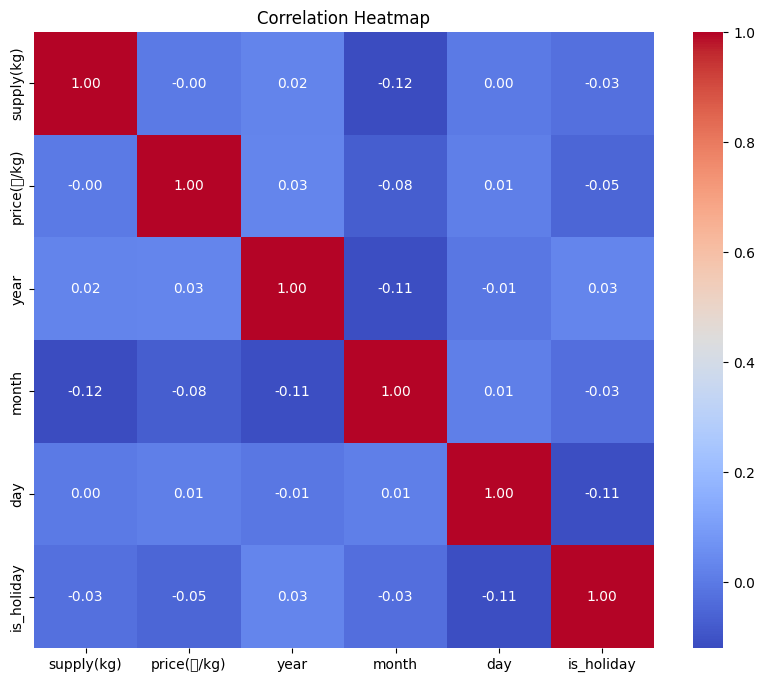

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

- price 랑 supply 관계 없으니까 걍 빼고 모델 만들어보기

In [ ]:
#학습에 사용하지 않을 변수들을 제거합니다
train_xs = train_df.drop(columns=['ID', 'timestamp', 'price(원/kg)', 'supply(kg)', 'day'])
train_ys = train_df['supply(kg)']

test_xs = test_df.drop(columns=['ID', 'timestamp', 'day'])

In [ ]:
#질적 변수들을 수치화합니다
qual_col = ['item', 'corporation', 'location', 'day_of_week']

for i in qual_col:
    le = LabelEncoder()
    train_xs[i]=le.fit_transform(train_xs[i])
    test_xs[i]=le.transform(test_xs[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

print('Done.')

Done.


In [ ]:
models = RandomForestRegressor(n_estimators=200, min_samples_split = 4, min_samples_leaf = 2, max_features = 'log2')
models.fit(train_xs, train_ys)

preds_s = models.predict(test_xs)

In [ ]:
test_df['supply(kg)'] = preds_s

In [ ]:
test_df

,ID,timestamp,item,corporation,location,year,month,day,day_of_week,is_holiday,supply(kg)
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,3,4,Saturday,0,8498.881584
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,3,5,Sunday,0,2491.073020
2,TG_A_J_20230306,2023-03-06,TG,A,J,2023,3,6,Monday,0,9025.264792
3,TG_A_J_20230307,2023-03-07,TG,A,J,2023,3,7,Tuesday,0,7104.716887
4,TG_A_J_20230308,2023-03-08,TG,A,J,2023,3,8,Wednesday,0,6613.644545
...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,RD,F,J,2023,3,27,Monday,0,464816.129986
1088,RD_F_J_20230328,2023-03-28,RD,F,J,2023,3,28,Tuesday,0,461973.890452
1089,RD_F_J_20230329,2023-03-29,RD,F,J,2023,3,29,Wednesday,0,444924.972178
1090,RD_F_J_20230330,2023-03-30,RD,F,J,2023,3,30,Thursday,0,450290.035245


- n_estimators : 앙상블에 사용될 트리 개수, 디폴트 100
- min_samples_split : 노드 분할 위해 필요한 최소 샘플 수, 디폴트 2
- min_samples_leaf : 리프 노드가 되기 위해 필요한 최소 샘플 수, 디폴트 1
- max_features : 분할시 고려할 feature 개수, 디폴트 : sqrt 또는 auto

In [ ]:
#학습에 사용하지 않을 변수들을 제거합니다
train_x = train_df.drop(columns=['ID', 'price(원/kg)', 'day'])
train_y = train_df['price(원/kg)']

test_x = test_df.drop(columns=['ID', 'day'])

In [ ]:
#질적 변수들을 수치화합니다
qual_col = ['item', 'corporation', 'location', 'day_of_week']

for i in qual_col:
    le = LabelEncoder()
    train_x[i]=le.fit_transform(train_x[i])
    test_x[i]=le.transform(test_x[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

print('Done.')

Done.


- 시계열 분해의 잔차 추가

In [ ]:
# timestamp 열을 datetime 형식으로 변환
train_x['timestamp'] = pd.to_datetime(train_x['timestamp'])

# 시계열 분해 수행
result = seasonal_decompose(train_x.set_index('timestamp')['supply(kg)'], model='additive', period = 7)

# 잔차(Residual) 추출
residuals = result.resid

# 잔차를 train_x 데이터프레임에 추가
train_x['잔차'] = residuals.values

In [ ]:
# timestamp 열을 datetime 형식으로 변환
test_x['timestamp'] = pd.to_datetime(test_x['timestamp'])

# 시계열 분해 수행
result = seasonal_decompose(test_x.set_index('timestamp')['supply(kg)'], model='additive', period = 7)

# 잔차(Residual) 추출
residuals = result.resid

# 잔차를 test_x 데이터프레임에 추가
test_x['잔차'] = residuals.values

In [ ]:
train_x['잔차'] = train_x['잔차'].fillna(train_x['잔차'].mean())
test_x['잔차'] = test_x['잔차'].fillna(test_x['잔차'].mean())

In [ ]:
train_x['잔차'] = train_x['잔차'].astype('object')
test_x['잔차'] = test_x['잔차'].astype('object')

In [ ]:
train_x = train_x.drop(columns=['timestamp'])
test_x = test_x.drop(columns=['timestamp'])

In [ ]:
test_x = test_x[['item', 'corporation', 'location', 'supply(kg)', 'year', 'month', 'day_of_week', 'is_holiday', '잔차']]

In [ ]:
train_x

,item,corporation,location,supply(kg),year,month,day_of_week,is_holiday,잔차
0,4,0,0,0.0,2019,1,5,1,-0.967437
1,4,0,0,0.0,2019,1,6,0,-0.967437
2,4,0,0,60601.0,2019,1,4,0,-0.967437
3,4,0,0,25000.0,2019,1,0,0,2193.738806
4,4,0,0,32352.0,2019,1,2,0,3945.407316
...,...,...,...,...,...,...,...,...,...
59392,3,5,0,452440.0,2023,2,1,0,100489.055919
59393,3,5,0,421980.0,2023,2,5,0,76065.464685
59394,3,5,0,382980.0,2023,3,6,1,-0.967437
59395,3,5,0,477220.0,2023,3,4,0,-0.967437


## 그냥 예측

In [ ]:
model = RandomForestRegressor(n_estimators=1000, min_samples_split = 2, min_samples_leaf = 1, max_features = None)
model.fit(train_x, train_y)

preds = model.predict(test_x)

- extra는 쓰지 말자 ~

In [ ]:
# from sklearn.ensemble import ExtraTreesRegressor

# model = ExtraTreesRegressor(n_estimators=1000, min_samples_split = 2, min_samples_leaf = 1, max_features = None)
# model.fit(train_x, train_y)

# preds = model.predict(test_x)

In [ ]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

feature_names = train_x.columns

plt.figure(figsize=(10, 6))
plt.bar(range(train_x.shape[1]), importances[indices], align="center")
plt.xticks(range(train_x.shape[1]), feature_names[indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

predic = model.predict(train_x)

rmse = np.sqrt(mean_squared_error(train_y, predic))

print('RMSE 정확도:', rmse)

RMSE 정확도: 753.8852368607105


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/open_jeju/sample_submission.csv')

In [ ]:
submission['answer'] = preds
submission

,ID,answer
0,TG_A_J_20230304,4000.404706
1,TG_A_J_20230305,0.000000
2,TG_A_J_20230306,3804.121473
3,TG_A_J_20230307,3584.927217
4,TG_A_J_20230308,3891.385390
...,...,...
1087,RD_F_J_20230327,517.571751
1088,RD_F_J_20230328,503.684458
1089,RD_F_J_20230329,517.300327
1090,RD_F_J_20230330,526.744478


In [ ]:
submission.to_csv('./baseline_submission.csv', index=False)

## 뭐냐 이건

In [ ]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 8.9 M

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [ ]:
train_df['item_id'] = train_df.ID.str[0:6]
test_df['item_id'] = test_df.ID.str[0:6]

In [ ]:

train_df

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,day_of_week,is_holiday,corona_weight,day_weight,item_id
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,Tuesday,1,2.0,2,TG_A_J
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,Wednesday,0,2.0,2,TG_A_J
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,Thursday,0,2.0,2,TG_A_J
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,Friday,0,2.0,2,TG_A_J
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,Saturday,0,2.0,1,TG_A_J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,27,Monday,0,2.0,2,RD_F_J
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,28,Tuesday,0,2.0,2,RD_F_J
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,1,Wednesday,1,2.0,2,RD_F_J
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,2,Thursday,0,2.0,2,RD_F_J


In [ ]:
train_x['item_id'] = train_df['item_id']
train_x['timestamp'] = train_df['timestamp']
train_x['price(원/kg)'] = train_df['price(원/kg)']

In [ ]:
train_x

,item,corporation,location,year,month,day_of_week,is_holiday,corona_weight,day_weight,item_id,timestamp,price(원/kg)
0,4,0,0,2019,1,5,1,2.0,2,TG_A_J,2019-01-01,0.0
1,4,0,0,2019,1,6,0,2.0,2,TG_A_J,2019-01-02,0.0
2,4,0,0,2019,1,4,0,2.0,2,TG_A_J,2019-01-03,1728.0
3,4,0,0,2019,1,0,0,2.0,2,TG_A_J,2019-01-04,1408.0
4,4,0,0,2019,1,2,0,2.0,1,TG_A_J,2019-01-05,1250.0
...,...,...,...,...,...,...,...,...,...,...,...,...
59392,3,5,0,2023,2,1,0,2.0,2,RD_F_J,2023-02-27,468.0
59393,3,5,0,2023,2,5,0,2.0,2,RD_F_J,2023-02-28,531.0
59394,3,5,0,2023,3,6,1,2.0,2,RD_F_J,2023-03-01,574.0
59395,3,5,0,2023,3,4,0,2.0,2,RD_F_J,2023-03-02,523.0


In [ ]:
data = TimeSeriesDataFrame(train_x.drop(columns=['year', 'month', 'is_holiday']))
predictor = TimeSeriesPredictor(
    prediction_length=28,
    target="price(원/kg)",
    eval_metric="RMSE",
    ignore_time_index=True
)
# seed 고정
predictor.fit( data, random_seed=42, )

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'default',
 'num_val_windows': 1,
 'prediction_length': 28,
 'random_seed': 42,
 'target': 'price(원/kg)',
 'time_limit': None,
 'verbosity': 2}
Provided training data set with 59373 rows, 39 items (item = single time series). Average time series length is 1522.4. Data frequency is 'S'.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
AutoGluon will save models to AutogluonModels/ag-20231114_061617/
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'price(원/kg)'
	past covariates:  ['item', 'corpo

In [ ]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: Naive_FULL | Skipping fit via cloning parent ...
Fitting model: SeasonalNaive_FULL | Skipping fit via cloning parent ...
Fitting model: Theta_FULL | Skipping fit via cloning parent ...
Fitting model: AutoETS_FULL | Skipping fit via cloning parent ...
Fitting model: RecursiveTabular_FULL
	5.12    s     = Training runtime
Fitting model: DeepAR_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['Naive_FULL', 'SeasonalNaive_FULL', 'Theta_FULL', 'AutoETS_FULL', 'RecursiveTabular_FULL', 'DeepAR_FULL', 'WeightedEnsemble_FULL']
Total runtime: 5.21 s
Updated best model to 'WeightedEnsemble_FULL' (Previously 'W

{'Naive': 'Naive_FULL',
 'SeasonalNaive': 'SeasonalNaive_FULL',
 'Theta': 'Theta_FULL',
 'AutoETS': 'AutoETS_FULL',
 'RecursiveTabular': 'RecursiveTabular_FULL',
 'DeepAR': 'DeepAR_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

In [ ]:
pred = predictor.predict(data, random_seed=42, )

INFO:lightning_fabric.utilities.seed:Global seed set to 42
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/open_jeju/sample_submission.csv')

submission['answer'] = pred.reset_index()['mean']
submission.loc[ submission['answer'] < 0.0, 'answer'] = 0.0

submission

,ID,answer
0,TG_A_J_20230304,3194.630736
1,TG_A_J_20230305,1804.641294
2,TG_A_J_20230306,3323.832514
3,TG_A_J_20230307,3323.600518
4,TG_A_J_20230308,3473.310500
...,...,...
1087,RD_F_J_20230327,416.057985
1088,RD_F_J_20230328,437.145416
1089,RD_F_J_20230329,449.754420
1090,RD_F_J_20230330,442.722187


In [ ]:
submission.to_csv('./baseline_submission.csv', index=False)

## OLS 분석

In [ ]:
#학습에 사용하지 않을 변수들을 제거합니다
train_xx = train_df.drop(columns=['ID', 'timestamp', 'price(원/kg)', 'supply(kg)'])
train_yy = train_df['price(원/kg)']

#질적 변수들을 수치화합니다
qual_col = ['item', 'corporation', 'location', 'day_of_week']

for i in qual_col:
    le = LabelEncoder()
    train_xx[i]=le.fit_transform(train_xx[i])

print('Done.')

Done.


train_xx = train_df.drop(columns=['ID', 'timestamp', 'price(원/kg)', 'supply(kg)']) <br>
train_yy = train_df['price(원/kg)']

In [ ]:
import statsmodels.api as sm

train_xx = sm.add_constant(train_xx)
model = sm.OLS(train_yy, train_xx).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price(원/kg)   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     1132.
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:34:29   Log-Likelihood:            -5.3191e+05
No. Observations:               59394   AIC:                         1.064e+06
Df Residuals:                   59384   BIC:                         1.064e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -7.5e+04   1.31e+04     -5.727      0.000   -1.01e+05   -4.93e+04
item            484.6041      5.146     94.163      0.000     474.517     494.691
corporation    -132.8903      4.809    -27.636      0.000    -142.315    -123.465
location        -20.5100     15.796     -1.298      0.194     -51.469      10.449
year             37.4580      6.479      5.781      0.000      24.759      50.157
month           -43.5975      2.215    -19.686      0.000     -47.938     -39.257
day               1.5218      0.880      1.729      0.084      -0.203       3.246
day_of_week       4.1973      3.846      1.091      0.275      -3.341      11.736
is_holiday     -528.3995     35.387    -14.932      0.000    -597.759    -459.040
sample_weight   -13.7626     15.673     -0.878      0.380     -44.482      16.957
==============================================================================
Omnibus:                    20384.612   Durbin-Watson:                   0.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63615.938
Skew:                           1.798   Prob(JB):                         0.00
Kurtosis:                       6.575   Cond. No.                     3.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
train_xxx = train_df.drop(columns=['ID', 'timestamp', 'price(원/kg)', 'supply(kg)', 'day', 'day_of_week'])
train_yyy = train_df['price(원/kg)']

#질적 변수들을 수치화합니다
qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train_xxx[i]=le.fit_transform(train_xxx[i])

print('Done.')

Done.


In [ ]:
import statsmodels.api as sm

train_xxx = sm.add_constant(train_xxx)
model = sm.OLS(train_yyy, train_xxx).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price(원/kg)   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     1697.
Date:                Thu, 09 Nov 2023   Prob (F-statistic):               0.00
Time:                        07:34:18   Log-Likelihood:            -5.3194e+05
No. Observations:               59397   AIC:                         1.064e+06
Df Residuals:                   59390   BIC:                         1.064e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.593e+04    1.3e+04     -5.823      0.000   -1.01e+05   -5.04e+04
item          484.5410      5.146     94.152      0.000     474.454     494.628
corporation  -132.8645      4.809    -27.631      0.000    -142.289    -123.440
location      -20.3388     15.795     -1.288      0.198     -51.298      10.620
year           37.9269      6.452      5.878      0.000      25.280      50.573
month         -43.7481      2.202    -19.870      0.000     -48.064     -39.433
is_holiday   -536.1247     35.155    -15.250      0.000    -605.029    -467.221
==============================================================================
Omnibus:                    20387.835   Durbin-Watson:                   0.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63625.432
Skew:                           1.798   Prob(JB):                         0.00
Kurtosis:                       6.575   Cond. No.                     3.42e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""